In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install git+https://github.com/Verified-Intelligence/auto_LiRPA

Looking in indexes: https://download.pytorch.org/whl/cu118
  Cloning https://github.com/Verified-Intelligence/auto_LiRPA to /tmp/pip-req-build-ysdv9n1k
  Running command git clone --filter=blob:none --quiet https://github.com/Verified-Intelligence/auto_LiRPA /tmp/pip-req-build-ysdv9n1k
  Resolved https://github.com/Verified-Intelligence/auto_LiRPA to commit 9d100ec070868440b48d34e2f1dd21b97aab9172
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.4/536.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.2 MB/s eta 0:00:0

Epoch 1: train=0.3014 val=0.1859


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 2: train=0.0588 val=0.0063
Epoch 3: train=0.0423 val=0.0378
Epoch 4: train=0.0549 val=0.0215
Epoch 5: train=0.0642 val=0.0447
Epoch 6: train=0.0448 val=0.0301
Epoch 7: train=0.0377 val=0.0498
Epoch 8: train=0.0327 val=0.0336
Epoch 9: train=0.0284 val=0.0563
Epoch 10: train=0.0270 val=0.0277
Epoch 11: train=0.0247 val=0.0181
Epoch 12: train=0.0242 val=0.0300
Early stop
RMSE: 29.024930563883892
MAE : 27.849531173706055
R2  : 0.8244872093200684


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


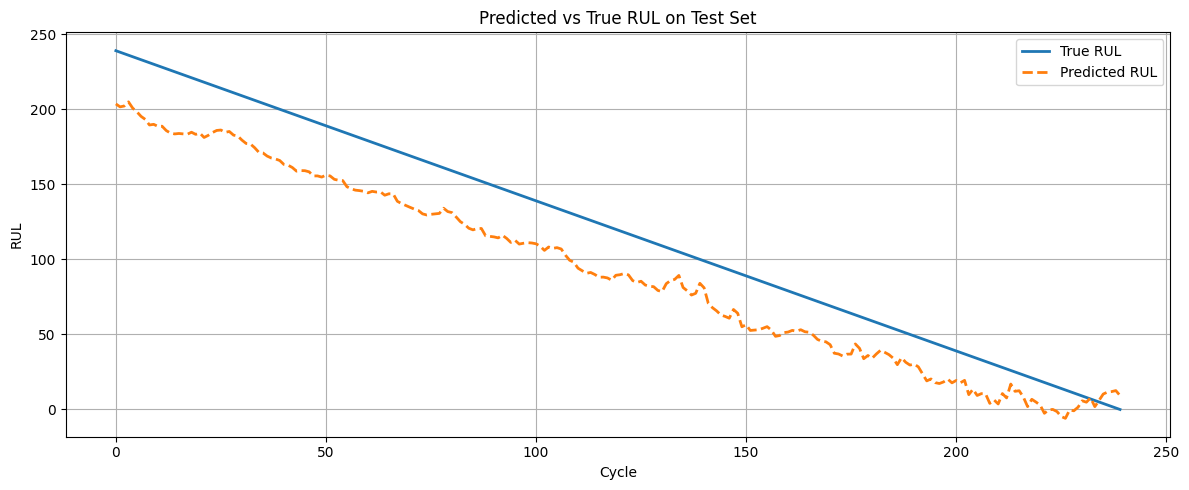

Sample 0
lower bound: -0.00031284766737371683
upper bound: 6.116497388575226e-07
Inconclusive
Sample 1
lower bound: -0.00032707033096812665
upper bound: -4.068169801030308e-08
Monotonic certified
Sample 2
lower bound: -0.0003188990231137723
upper bound: 2.7848000172525644e-07
Inconclusive
Sample 3
lower bound: -0.0003119141620118171
upper bound: 2.72730176220648e-07
Inconclusive
Sample 4
lower bound: -0.0002737460599746555
upper bound: -3.4942786442115903e-09
Monotonic certified
Sample 5
lower bound: -0.0002793450257740915
upper bound: 5.85597717872588e-07
Inconclusive
Sample 6
lower bound: -0.00025979653582908213
upper bound: -1.0711028153309599e-07
Monotonic certified
Sample 7
lower bound: -0.00027359131490811706
upper bound: 1.4178112905938178e-08
Inconclusive
Sample 8
lower bound: -0.000262780929915607
upper bound: 1.8888113118009642e-07
Inconclusive
Sample 9
lower bound: -0.0002388849388808012
upper bound: 1.509451976744458e-07
Inconclusive
Sample 10
lower bound: -0.00024088872305

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm
import torch.nn.functional as F
import math

df = pd.read_csv("/content/Battery_dataset.csv")

target_col = "RUL"
seq_len = 10

df["battery_id"] = df["battery_id"].astype(str).str.upper().str.strip()

cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != "battery_id"]
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

train_bats = ["B5", "B6"]
test_bats = ["B7"]

train_df = df[df["battery_id"].isin(train_bats)].reset_index(drop=True)
test_df = df[df["battery_id"].isin(test_bats)].reset_index(drop=True)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_raw = train_df.drop(columns=[target_col, "battery_id"]).values
y_train_raw = train_df[target_col].values.reshape(-1, 1)

scaler_x.fit(X_train_raw)
scaler_y.fit(y_train_raw)

def prepare(df_):
    X = df_.drop(columns=[target_col, "battery_id"]).values
    y = df_[target_col].values.reshape(-1, 1)
    return scaler_x.transform(X), scaler_y.transform(y)

b6_df = df[df["battery_id"] == "B6"].reset_index(drop=True)
b6_X, b6_y = prepare(b6_df)
split = int(0.85 * len(b6_X))
X_b6_train, y_b6_train = b6_X[:split], b6_y[:split]
X_b6_val, y_b6_val = b6_X[split:], b6_y[split:]

b5_df = df[df["battery_id"] == "B5"].reset_index(drop=True)
X_b5, y_b5 = prepare(b5_df)

X_train = np.concatenate([X_b5, X_b6_train], axis=0)
y_train = np.concatenate([y_b5, y_b6_train], axis=0)

X_val, y_val = X_b6_val, y_b6_val
X_test, y_test = prepare(test_df)

def make_seq(X, y, L):
    out_x, out_y = [], []
    for i in range(len(X) - L):
        out_x.append(X[i:i+L])
        out_y.append(y[i+L])
    return np.array(out_x), np.array(out_y)

X_train_seq, y_train_seq = make_seq(X_train, y_train, seq_len)
X_val_seq, y_val_seq = make_seq(X_val, y_val, seq_len)
X_test_seq, y_test_seq = make_seq(X_test, y_test, seq_len)

X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_seq = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_seq = torch.tensor(y_val_seq, dtype=torch.float32)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32)

class SeqData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SeqData(X_train_seq, y_train_seq), batch_size=32, shuffle=True)
val_loader = DataLoader(SeqData(X_val_seq, y_val_seq), batch_size=32, shuffle=False)
test_loader = DataLoader(SeqData(X_test_seq, y_test_seq), batch_size=32, shuffle=False)


class MHAttention_NoSoftmax(nn.Module):
    def __init__(self, d_model, nhead):
        super().__init__()
        assert d_model % nhead == 0
        self.nhead = nhead
        self.dk = d_model // nhead
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        q = self.Wq(x).view(B, T, self.nhead, self.dk).transpose(1, 2)
        k = self.Wk(x).view(B, T, self.nhead, self.dk).transpose(1, 2)
        v = self.Wv(x).view(B, T, self.nhead, self.dk).transpose(1, 2)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.dk)
        attn = F.relu(scores)
        out = attn @ v
        out = out.transpose(1, 2).reshape(B, T, D)
        return self.proj(out)

class Block(nn.Module):
    def __init__(self, d_model, nhead, dim_ff):
        super().__init__()
        self.attn = MHAttention_NoSoftmax(d_model, nhead)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(),
            nn.Linear(dim_ff, d_model)
        )

    def forward(self, x):
        x = x + self.attn(x)
        x = x + self.ff(x)
        return x

class TransformerReg(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=2, num_layers=2, dim_ff=128):
        super().__init__()
        self.proj = nn.Linear(input_dim, d_model)
        self.layers = nn.ModuleList([Block(d_model, nhead, dim_ff) for _ in range(num_layers)])
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.proj(x)
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=1)
        return self.regressor(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerReg(input_dim=X_train_seq.shape[-1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_val = 1e9
patience = 10
no_improve = 0

for ep in range(80):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item()
    val_loss /= len(val_loader)

    print(f"Epoch {ep+1}: train={train_loss:.4f} val={val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        best_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stop")
            break

model.load_state_dict(best_state)

model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds.append(model(xb.to(device)).cpu())
        trues.append(yb)

preds = torch.cat(preds).numpy()
trues = torch.cat(trues).numpy()

preds_d = scaler_y.inverse_transform(preds)
trues_d = scaler_y.inverse_transform(trues)

rmse = np.sqrt(mean_squared_error(trues_d, preds_d))
mae = mean_absolute_error(trues_d, preds_d)
r2 = r2_score(trues_d, preds_d)

print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)

plt.figure(figsize=(12, 5))
plt.plot(trues_d, label="True RUL", linewidth=2)
plt.plot(preds_d, label="Predicted RUL", linewidth=2, linestyle="--")
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title("Predicted vs True RUL on Test Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

class DiffModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.f = base_model
    def forward(self, x):
        x1 = x[:, 0]
        x0 = x[:, 1]
        y1 = self.f(x1)
        y0 = self.f(x0)
        return y1 - y0

cycle_idx = 0
delta = 0.001

diff_model = DiffModel(model).to(device)
example_pair = torch.zeros((1, 2, seq_len, X_train_seq.shape[-1]), device=device)
bound_diff_model = BoundedModule(diff_model, example_pair, device=device)

N_verify = len(X_test_seq)

certified_cnt = 0
violated_cnt = 0
inconclusive_cnt = 0

for i in range(N_verify):
    x0 = X_test_seq[i:i+1].to(device)

    lb1 = x0.clone()
    ub1 = x0.clone()
    ub1[:, :, cycle_idx] += delta

    lb0 = x0.clone()
    ub0 = x0.clone()

    lb_pair = torch.stack([lb1, lb0], dim=1)
    ub_pair = torch.stack([ub1, ub0], dim=1)
    x_pair = torch.stack([x0, x0], dim=1)

    ptb = PerturbationLpNorm(norm=np.inf, eps=1.0, x_L=lb_pair, x_U=ub_pair)
    x_bounded = BoundedTensor(x_pair, ptb)

    lb, ub = bound_diff_model.compute_bounds(
        x=(x_bounded,),
        method="CROWN",
        bound_lower=True,
        bound_upper=True
    )

    lb_val = lb.item()
    ub_val = ub.item()

    print(f"Sample {i}")
    print("lower bound:", lb_val)
    print("upper bound:", ub_val)

    if ub_val <= 0:
        print("Monotonic certified")
        certified_cnt += 1
    elif lb_val > 0:
        print("Monotonicity violated")
        violated_cnt += 1
    else:
        print("Inconclusive")
        inconclusive_cnt += 1

print("Certified:", certified_cnt)
print("Violated:", violated_cnt)
print("Inconclusive:", inconclusive_cnt)


In [ ]:
certified_cnt  = 0
violated_cnt = 0
inconclusive_cnt = 0
for i in range(N_verify):
    x0 = X_test_seq[i:i+1].to(device)

    lb1 = x0.clone()
    ub1 = x0.clone()
    ub1[:, :, cycle_idx] += delta

    lb0 = x0.clone()
    ub0 = x0.clone()

    lb_pair = torch.stack([lb1, lb0], dim=1)
    ub_pair = torch.stack([ub1, ub0], dim=1)
    x_pair = torch.stack([x0, x0], dim=1)

    ptb = PerturbationLpNorm(norm=np.inf, eps=1.0, x_L=lb_pair, x_U=ub_pair)
    x_bounded = BoundedTensor(x_pair, ptb)

    lb, ub = bound_diff_model.compute_bounds(
        x=(x_bounded,),
        method="CROWN-IBP",
        bound_lower=True,
        bound_upper=True
    )

    lb_val = lb.item()
    ub_val = ub.item()

    print(f"Sample {i}")
    print("lower bound:", lb_val)
    print("upper bound:", ub_val)

    if ub_val <= 0:
        print("Monotonic non-increasing certified")
        certified_cnt += 1
    elif lb_val > 0:
        print("Monotonicity violated")
        violated_cnt += 1
    else:
        print("Inconclusive")
        inconclusive_cnt += 1

print("Certified:", certified_cnt)
print("Violated:", violated_cnt)
print("Inconclusive:", inconclusive_cnt)


Sample 0
lower bound: -12.779523849487305
upper bound: 9.391247749328613
Inconclusive
Sample 1
lower bound: -11.72446346282959
upper bound: 8.588932037353516
Inconclusive
Sample 2
lower bound: -9.20742130279541
upper bound: 6.698268890380859
Inconclusive
Sample 3
lower bound: -10.923209190368652
upper bound: 8.024772644042969
Inconclusive
Sample 4
lower bound: -16.262876510620117
upper bound: 12.133389472961426
Inconclusive
Sample 5
lower bound: -20.492786407470703
upper bound: 15.444963455200195
Inconclusive
Sample 6
lower bound: -35.40335464477539
upper bound: 27.144792556762695
Inconclusive
Sample 7
lower bound: -22.213361740112305
upper bound: 16.818803787231445
Inconclusive
Sample 8
lower bound: -28.499473571777344
upper bound: 21.83287239074707
Inconclusive
Sample 9
lower bound: -53.20167541503906
upper bound: 41.02909851074219
Inconclusive
Sample 10
lower bound: -50.540252685546875
upper bound: 39.01652145385742
Inconclusive
Sample 11
lower bound: -47.43532180786133
upper bound:

Epoch 1: train=0.2843 val=0.1767


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 2: train=0.0775 val=0.5006
Epoch 3: train=0.0866 val=0.0115
Epoch 4: train=0.0607 val=0.0374
Epoch 5: train=0.0434 val=0.0596
Epoch 6: train=0.0367 val=0.0195
Epoch 7: train=0.0522 val=0.0177
Epoch 8: train=0.0411 val=0.0678
Epoch 9: train=0.0412 val=0.0232
Epoch 10: train=0.0307 val=0.0624
Epoch 11: train=0.0366 val=0.0176
Epoch 12: train=0.0406 val=0.0105
Epoch 13: train=0.0307 val=0.0393
Epoch 14: train=0.0208 val=0.0224
Epoch 15: train=0.0142 val=0.0229
Epoch 16: train=0.0191 val=0.0311
Epoch 17: train=0.0252 val=0.0131
Epoch 18: train=0.0275 val=0.0777
Epoch 19: train=0.0266 val=0.0156
Epoch 20: train=0.0464 val=0.0534
Epoch 21: train=0.0349 val=0.0548
Epoch 22: train=0.0257 val=0.0745
Early stop
RMSE: 27.485891711277304
MAE : 25.579235076904297
R2  : 0.842606782913208


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


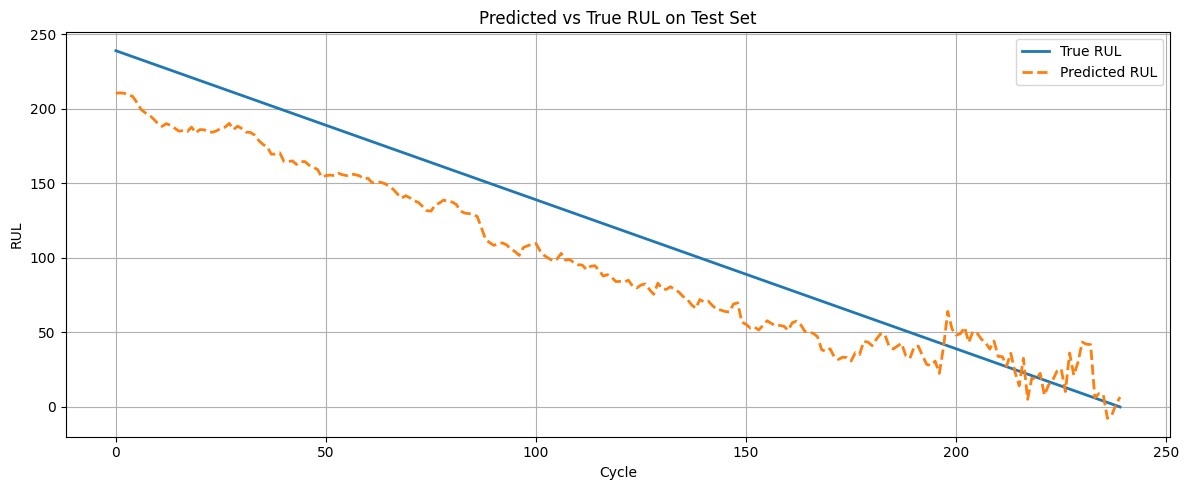

Sample 0
lower bound: -0.0002996066177729517
upper bound: 1.1088718565588351e-07
Inconclusive
Sample 1
lower bound: -0.0002992795198224485
upper bound: 6.191031047819706e-07
Inconclusive
Sample 2
lower bound: -0.0002923128195106983
upper bound: -2.0979190651360113e-07
Monotonic certified
Sample 3
lower bound: -0.0002890576724894345
upper bound: 4.094792984687956e-07
Inconclusive
Sample 4
lower bound: -0.00031413199030794203
upper bound: 6.272388191064238e-07
Inconclusive
Sample 5
lower bound: -0.0003432087250985205
upper bound: 4.3084872913823347e-07
Inconclusive
Sample 6
lower bound: -0.00038277983549050987
upper bound: -2.574759889739653e-07
Monotonic certified
Sample 7
lower bound: -0.0003608090919442475
upper bound: 1.6674835023877677e-07
Inconclusive
Sample 8
lower bound: -0.00037495538708753884
upper bound: 3.497439138300251e-07
Inconclusive
Sample 9
lower bound: -0.0003308890445623547
upper bound: 2.9592658279398165e-07
Inconclusive
Sample 10
lower bound: -0.0003657151246443391


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm
import torch.nn.functional as F
import math

df = pd.read_csv("/content/Battery_dataset.csv")

target_col = "RUL"
seq_len = 10

df["battery_id"] = df["battery_id"].astype(str).str.upper().str.strip()

cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != "battery_id"]
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

train_bats = ["B5", "B6"]
test_bats = ["B7"]

train_df = df[df["battery_id"].isin(train_bats)].reset_index(drop=True)
test_df = df[df["battery_id"].isin(test_bats)].reset_index(drop=True)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_raw = train_df.drop(columns=[target_col, "battery_id"]).values
y_train_raw = train_df[target_col].values.reshape(-1, 1)

scaler_x.fit(X_train_raw)
scaler_y.fit(y_train_raw)

def prepare(df_):
    X = df_.drop(columns=[target_col, "battery_id"]).values
    y = df_[target_col].values.reshape(-1, 1)
    return scaler_x.transform(X), scaler_y.transform(y)

b6_df = df[df["battery_id"] == "B6"].reset_index(drop=True)
b6_X, b6_y = prepare(b6_df)
split = int(0.85 * len(b6_X))
X_b6_train, y_b6_train = b6_X[:split], b6_y[:split]
X_b6_val, y_b6_val = b6_X[split:], b6_y[split:]

b5_df = df[df["battery_id"] == "B5"].reset_index(drop=True)
X_b5, y_b5 = prepare(b5_df)

X_train = np.concatenate([X_b5, X_b6_train], axis=0)
y_train = np.concatenate([y_b5, y_b6_train], axis=0)

X_val, y_val = X_b6_val, y_b6_val
X_test, y_test = prepare(test_df)

def make_seq(X, y, L):
    out_x, out_y = [], []
    for i in range(len(X) - L):
        out_x.append(X[i:i+L])
        out_y.append(y[i+L])
    return np.array(out_x), np.array(out_y)

X_train_seq, y_train_seq = make_seq(X_train, y_train, seq_len)
X_val_seq, y_val_seq = make_seq(X_val, y_val, seq_len)
X_test_seq, y_test_seq = make_seq(X_test, y_test, seq_len)

X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_seq = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_seq = torch.tensor(y_val_seq, dtype=torch.float32)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32)

class SeqData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SeqData(X_train_seq, y_train_seq), batch_size=32, shuffle=True)
val_loader = DataLoader(SeqData(X_val_seq, y_val_seq), batch_size=32, shuffle=False)
test_loader = DataLoader(SeqData(X_test_seq, y_test_seq), batch_size=32, shuffle=False)

class MHAttention_NoSoftmax(nn.Module):
    def __init__(self, d_model, nhead):
        super().__init__()
        assert d_model % nhead == 0
        self.nhead = nhead
        self.dk = d_model // nhead
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        q = self.Wq(x).view(B, T, self.nhead, self.dk).transpose(1, 2)
        k = self.Wk(x).view(B, T, self.nhead, self.dk).transpose(1, 2)
        v = self.Wv(x).view(B, T, self.nhead, self.dk).transpose(1, 2)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.dk)
        attn = scores
        out = attn @ v
        out = out.transpose(1, 2).reshape(B, T, D)
        return self.proj(out)

class Block(nn.Module):
    def __init__(self, d_model, nhead, dim_ff):
        super().__init__()
        self.attn = MHAttention_NoSoftmax(d_model, nhead)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.LeakyReLU(0.01),
            nn.Linear(dim_ff, d_model)
        )

    def forward(self, x):
        x = x + self.attn(x)
        x = x + self.ff(x)
        return x

class TransformerReg(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=2, num_layers=2, dim_ff=128):
        super().__init__()
        self.proj = nn.Linear(input_dim, d_model)
        self.layers = nn.ModuleList([Block(d_model, nhead, dim_ff) for _ in range(num_layers)])
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.proj(x)
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=1)
        return self.regressor(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerReg(input_dim=X_train_seq.shape[-1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

best_val = 1e9
patience = 10
no_improve = 0

for ep in range(80):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item()
    val_loss /= len(val_loader)

    print(f"Epoch {ep+1}: train={train_loss:.4f} val={val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        best_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stop")
            break

model.load_state_dict(best_state)

model.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds.append(model(xb.to(device)).cpu())
        trues.append(yb)

preds = torch.cat(preds).numpy()
trues = torch.cat(trues).numpy()

preds_d = scaler_y.inverse_transform(preds)
trues_d = scaler_y.inverse_transform(trues)

rmse = np.sqrt(mean_squared_error(trues_d, preds_d))
mae = mean_absolute_error(trues_d, preds_d)
r2 = r2_score(trues_d, preds_d)

print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)

plt.figure(figsize=(12, 5))
plt.plot(trues_d, label="True RUL", linewidth=2)
plt.plot(preds_d, label="Predicted RUL", linewidth=2, linestyle="--")
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title("Predicted vs True RUL on Test Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

class DiffModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.f = base_model
    def forward(self, x):
        x1 = x[:, 0]
        x0 = x[:, 1]
        y1 = self.f(x1)
        y0 = self.f(x0)
        return y1 - y0

cycle_idx = 0
delta = 0.001

diff_model = DiffModel(model).to(device)
example_pair = torch.zeros((1, 2, seq_len, X_train_seq.shape[-1]), device=device)
bound_diff_model = BoundedModule(diff_model, example_pair, device=device)

N_verify = len(X_test_seq)

certified_cnt = 0
violated_cnt = 0
inconclusive_cnt = 0

for i in range(N_verify):
    x0 = X_test_seq[i:i+1].to(device)

    lb1 = x0.clone()
    ub1 = x0.clone()
    ub1[:, :, cycle_idx] += delta

    lb0 = x0.clone()
    ub0 = x0.clone()

    lb_pair = torch.stack([lb1, lb0], dim=1)
    ub_pair = torch.stack([ub1, ub0], dim=1)
    x_pair = torch.stack([x0, x0], dim=1)

    ptb = PerturbationLpNorm(norm=np.inf, eps=1.0, x_L=lb_pair, x_U=ub_pair)
    x_bounded = BoundedTensor(x_pair, ptb)

    lb, ub = bound_diff_model.compute_bounds(
        x=(x_bounded,),
        method="CROWN",
        bound_lower=True,
        bound_upper=True
    )

    lb_val = lb.item()
    ub_val = ub.item()

    print(f"Sample {i}")
    print("lower bound:", lb_val)
    print("upper bound:", ub_val)

    if ub_val <= 0:
        print("Monotonic certified")
        certified_cnt += 1
    elif lb_val > 0:
        print("Monotonicity violated")
        violated_cnt += 1
    else:
        print("Inconclusive")
        inconclusive_cnt += 1

print("Certified:", certified_cnt)
print("Violated:", violated_cnt)
print("Inconclusive:", inconclusive_cnt)


In [ ]:
certified_cnt  = 0
violated_cnt = 0
inconclusive_cnt = 0
for i in range(N_verify):
    x0 = X_test_seq[i:i+1].to(device)

    lb1 = x0.clone()
    ub1 = x0.clone()
    ub1[:, :, cycle_idx] += delta

    lb0 = x0.clone()
    ub0 = x0.clone()

    lb_pair = torch.stack([lb1, lb0], dim=1)
    ub_pair = torch.stack([ub1, ub0], dim=1)
    x_pair = torch.stack([x0, x0], dim=1)

    ptb = PerturbationLpNorm(norm=np.inf, eps=1.0, x_L=lb_pair, x_U=ub_pair)
    x_bounded = BoundedTensor(x_pair, ptb)

    lb, ub = bound_diff_model.compute_bounds(
        x=(x_bounded,),
        method="CROWN-IBP",
        bound_lower=True,
        bound_upper=True
    )

    lb_val = lb.item()
    ub_val = ub.item()

    print(f"Sample {i}")
    print("lower bound:", lb_val)
    print("upper bound:", ub_val)

    if ub_val <= 0:
        print("Monotonic non-increasing certified")
        certified_cnt += 1
    elif lb_val > 0:
        print("Monotonicity violated")
        violated_cnt += 1
    else:
        print("Inconclusive")
        inconclusive_cnt += 1

print("Certified:", certified_cnt)
print("Violated:", violated_cnt)
print("Inconclusive:", inconclusive_cnt)

Sample 0
lower bound: -2457.645751953125
upper bound: 2829.456787109375
Inconclusive
Sample 1
lower bound: -2433.920166015625
upper bound: 2799.7626953125
Inconclusive
Sample 2
lower bound: -2049.3642578125
upper bound: 2355.22900390625
Inconclusive
Sample 3
lower bound: -1752.7506103515625
upper bound: 2012.659423828125
Inconclusive
Sample 4
lower bound: -1932.7889404296875
upper bound: 2220.185302734375
Inconclusive
Sample 5
lower bound: -2313.609375
upper bound: 2664.26611328125
Inconclusive
Sample 6
lower bound: -2292.40087890625
upper bound: 2642.224609375
Inconclusive
Sample 7
lower bound: -2116.46826171875
upper bound: 2441.089599609375
Inconclusive
Sample 8
lower bound: -2291.226806640625
upper bound: 2646.0966796875
Inconclusive
Sample 9
lower bound: -2247.485595703125
upper bound: 2603.083251953125
Inconclusive
Sample 10
lower bound: -2133.515380859375
upper bound: 2470.08544921875
Inconclusive
Sample 11
lower bound: -1998.3328857421875
upper bound: 2314.15771484375
Inconclus